#**Task Overview**#

The goal of this task is to detect deception in dialogues by training a logistic regression model using stochastic gradient descent (SGD). The dataset consists of text messages from a game where each message is labeled as truthful or deceptive.

##**Two text vectorization methods are used:**##

CountVectorizer (word frequency-based representation)

TF-IDF Vectorizer (importance-based representation)

**The model is trained separately for both vectorization methods, and their performance is compared.**


#**Installation of required files**#

In [1]:
# First install any required packages that aren't pre-installed in Colab
!pip install jsonlines spacy scikit-learn gdown

#**Importing necessary libraries**#

In [2]:
import jsonlines
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import log_loss, accuracy_score, f1_score
from scipy.sparse import csr_matrix
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import os
import gdown
import warnings
warnings.filterwarnings("ignore")

#**Dataset and Configuration**#
The dataset is stored in JSONL format and is downloaded from Google Drive if not available.

The dataset contains game dialogues, where players communicate with each other.

Each message is labeled as truthful or deceptive (sender_annotation or receiver_annotation).

The task can be configured to focus on either:

**SENDER**: Whether the sender is truthful or deceptive.

**RECEIVER**: Whether the receiver perceives the message as truthful or deceptive.

The "**POWER**" setting determines whether the model considers game score changes as additional features.

In [3]:
TASK = "SENDER"  # Can be "SENDER" or "RECEIVER"
POWER = "y"      # Can be "y" (include power) or "n" (exclude power)

# File IDs extracted from Google Drive links
FILE_IDS = {
    'train.jsonl': '1sHVikR018z4QEBmHPUVwRXoKmgv7G69q',
    'validation.jsonl': '1Y-MKTjzrrP8X8oTxB8yz9awilRsXSNS_',
    'test.jsonl': '1sDgZ98_OXsoCt5WxroXLSlwMcCUZp4zm'
}

DATA_DIR = 'data/'

print(f"Configuration: TASK={TASK}, POWER={POWER}")
def download_files():
    # Create data directory if it doesn't exist
    os.makedirs(DATA_DIR, exist_ok=True)

    # Download each file if it doesn't already exist
    for filename, file_id in FILE_IDS.items():
        filepath = os.path.join(DATA_DIR, filename)
        if not os.path.exists(filepath):
            url = f'https://drive.google.com/uc?id={file_id}'
            gdown.download(url, filepath, quiet=False)
            print(f"Downloaded {filename}")
        else:
            print(f"{filename} already exists, skipping download")

# Download the files
download_files()

Configuration: TASK=SENDER, POWER=y


Downloading...
From: https://drive.google.com/uc?id=1sHVikR018z4QEBmHPUVwRXoKmgv7G69q
To: /content/data/train.jsonl
100%|██████████| 2.47M/2.47M [00:00<00:00, 12.6MB/s]


Downloaded train.jsonl


Downloading...
From: https://drive.google.com/uc?id=1Y-MKTjzrrP8X8oTxB8yz9awilRsXSNS_
To: /content/data/validation.jsonl
100%|██████████| 246k/246k [00:00<00:00, 97.7MB/s]


Downloaded validation.jsonl


Downloading...
From: https://drive.google.com/uc?id=1sDgZ98_OXsoCt5WxroXLSlwMcCUZp4zm
To: /content/data/test.jsonl
100%|██████████| 490k/490k [00:00<00:00, 39.7MB/s]

Downloaded test.jsonl


#**Data Preprocessing**#
Messages are extracted from the dataset and converted to lowercase.

Stop words are removed using SpaCy.

###**Vectorization is applied to convert text into numerical format:**###

CountVectorizer creates a word frequency matrix.

TF-IDF Vectorizer assigns importance scores to words based on their rarity.

Additional power features (if enabled) are appended to the vectorized data.

In [4]:
# Initialize spaCy for tokenization
nlp = English()
def is_number(tok):
    try:
        float(tok)
        return True
    except ValueError:
        return False

def spacy_tokenizer(text):
    return [tok.text if not is_number(tok.text) else '_NUM_' for tok in nlp(text)]



In [5]:
# Data Aggregation
def aggregate(dataset):
    messages, rec, send, power = [], [], [], []
    for dialogs in dataset:
        messages.extend(dialogs['messages'])
        rec.extend(dialogs['receiver_labels'])
        send.extend(dialogs['sender_labels'])
        power.extend(dialogs['game_score_delta'])
    return [{'message': m, 'sender_annotation': s, 'receiver_annotation': r, 'score_delta': int(p)}
            for m, s, r, p in zip(messages, send, rec, power)]


def convert_to_binary(dataset):
    binary_data = []
    for message in dataset:
        if TASK == "RECEIVER" and message['receiver_annotation'] not in [True, False]:
            continue
        binary = []
        if POWER == "y":
            binary.extend([1 if message['score_delta'] > 4 else 0,
                          1 if message['score_delta'] < -4 else 0])
        binary.append(1 if message['sender_annotation' if TASK == "SENDER" else 'receiver_annotation'] else 0)
        binary_data.append(binary)
    return binary_data


def split_xy(data):
    return [line[:len(line)-1] for line in data], [line[len(line)-1] for line in data]

In [6]:
#Load data
with jsonlines.open(os.path.join(DATA_DIR, 'train.jsonl'), 'r') as reader:
    train = list(reader)
with jsonlines.open(os.path.join(DATA_DIR, 'test.jsonl'), 'r') as reader:
    test = list(reader)

#**Model Training (Logistic Regression with SGD)**#
##**SGDClassifier (Logistic Regression) is used with:**##

loss='log_loss' (logistic regression for binary classification)

max_iter=1 (single iteration per epoch)

warm_start=True (keeps learning across epochs)

penalty='l2', alpha=1e-4 (L2 regularization)

##**Learning Rate Decay:**##

Initial learning rate: eta0 = 0.01

Decay function: eta_t = eta0 / (1 + decay * epoch)


##**Class Imbalance Handling:**##

Class weights are computed using compute_class_weight('balanced', ...)

Sample weights are assigned based on class weights to balance the dataset.


##**Partial Fitting:**##

The model is trained iteratively for 100 epochs using partial_fit(), which updates weights without resetting them.

In [7]:
# Vectorization Options
vectorizer_types = ['count', 'tfidf']  # Run for both

results = {}

for vectorizer_type in vectorizer_types:
    print(f"\nRunning model with {vectorizer_type} vectorization\n")

    # Choose Vectorizer
    if vectorizer_type == 'count':
        vectorizer = CountVectorizer(stop_words=list(STOP_WORDS), strip_accents='unicode')
    else:
        vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS), strip_accents='unicode', max_features=5000)

    # Train and Test Data Vectorization
    corpus_train =[message['message'].lower() for message in aggregate(train)] if TASK == "SENDER" else [
    message['message'].lower() for message in aggregate(train)
    if message['receiver_annotation'] != "NOANNOTATION"]

    corpus_test = [message['message'].lower() for message in aggregate(test)] if TASK == "SENDER" else [
    message['message'].lower() for message in aggregate(test)
    if message['receiver_annotation'] != "NOANNOTATION"]

    X_train = vectorizer.fit_transform(corpus_train)
    X_test = vectorizer.transform(corpus_test)

    train_binary = convert_to_binary(aggregate(train))
    test_binary = convert_to_binary(aggregate(test))
    train_x, train_y = split_xy(train_binary)
    test_x, test_y = split_xy(test_binary)

    if POWER == "y":
        X_train_final = csr_matrix(np.append(X_train.toarray(), train_x, axis=1))
        X_test_final = csr_matrix(np.append(X_test.toarray(), test_x, axis=1))
    else:
        X_train_final = csr_matrix(X_train.toarray())
        X_test_final = csr_matrix(X_test.toarray())

    train_y = np.array(train_y)
    test_y = np.array(test_y)

    # Initialize SGDClassifier (Logistic Regression) with Learning Rate Decay
    eta0 = 0.01  # Initial learning rate
    decay = 0.1  # Decay rate

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(train_y), class_weights)}

    model = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, penalty='l2',alpha=1e-4)

    epochs = 100  # Define number of epochs
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_f1s, test_f1s = [], []

    for epoch in range(epochs):
        # Compute decayed learning rate
        eta_t = eta0 / (1 + decay * epoch)
        model.set_params(eta0=eta_t)

        # Compute sample weights based on class weights
        sample_weights = np.array([class_weight_dict[label] for label in train_y])

        # Train model using partial_fit with sample weights
        model.partial_fit(X_train_final, train_y, classes=np.unique(train_y), sample_weight=sample_weights)

        train_probs = model.predict_proba(X_train_final)
        test_probs = model.predict_proba(X_test_final)

        train_preds = model.predict(X_train_final)
        test_preds = model.predict(X_test_final)

        train_loss = log_loss(train_y, train_probs)
        test_loss = log_loss(test_y, test_probs)
        train_acc = accuracy_score(train_y, train_preds)
        test_acc = accuracy_score(test_y, test_preds)
        train_f1 = f1_score(train_y, train_preds)
        test_f1 = f1_score(test_y, test_preds)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

        print(f"Epoch {epoch+1}/{epochs}: Learning Rate={eta_t:.5f}, Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, "
              f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}, Train F1={train_f1:.4f}, Test F1={test_f1:.4f}")

    results[vectorizer_type] = {
        'train_losses': train_losses, 'test_losses': test_losses,
        'train_accuracies': train_accuracies, 'test_accuracies': test_accuracies,
        'train_f1s': train_f1s, 'test_f1s': test_f1s
    }




Running model with count vectorization

Epoch 1/100: Learning Rate=0.01000, Train Loss=3.4824, Test Loss=4.6960, Train Acc=0.6961, Test Acc=0.6344, Train F1=0.8141, Test F1=0.7665
Epoch 2/100: Learning Rate=0.00909, Train Loss=1.6142, Test Loss=2.5099, Train Acc=0.7732, Test Acc=0.6917, Train F1=0.8674, Test F1=0.8102
Epoch 3/100: Learning Rate=0.00833, Train Loss=1.0017, Test Loss=1.5791, Train Acc=0.7800, Test Acc=0.7180, Train F1=0.8713, Test F1=0.8286
Epoch 4/100: Learning Rate=0.00769, Train Loss=0.7405, Test Loss=1.2769, Train Acc=0.7974, Test Acc=0.7143, Train F1=0.8823, Test F1=0.8267
Epoch 5/100: Learning Rate=0.00714, Train Loss=0.9435, Test Loss=1.2743, Train Acc=0.7341, Test Acc=0.6706, Train F1=0.8392, Test F1=0.7933
Epoch 6/100: Learning Rate=0.00667, Train Loss=0.5282, Test Loss=0.9636, Train Acc=0.8248, Test Acc=0.7311, Train F1=0.8998, Test F1=0.8383
Epoch 7/100: Learning Rate=0.00625, Train Loss=0.3736, Test Loss=0.7681, Train Acc=0.8616, Test Acc=0.7603, Train F1=0.

#**Performance Evaluation**#
At each epoch, the model evaluates:

Train and Test Loss (**Log Loss**)

Train and Test Accuracy

Train and Test F1-Score

These metrics track how well the model is learning and generalizing.

#**Plotting of results**#

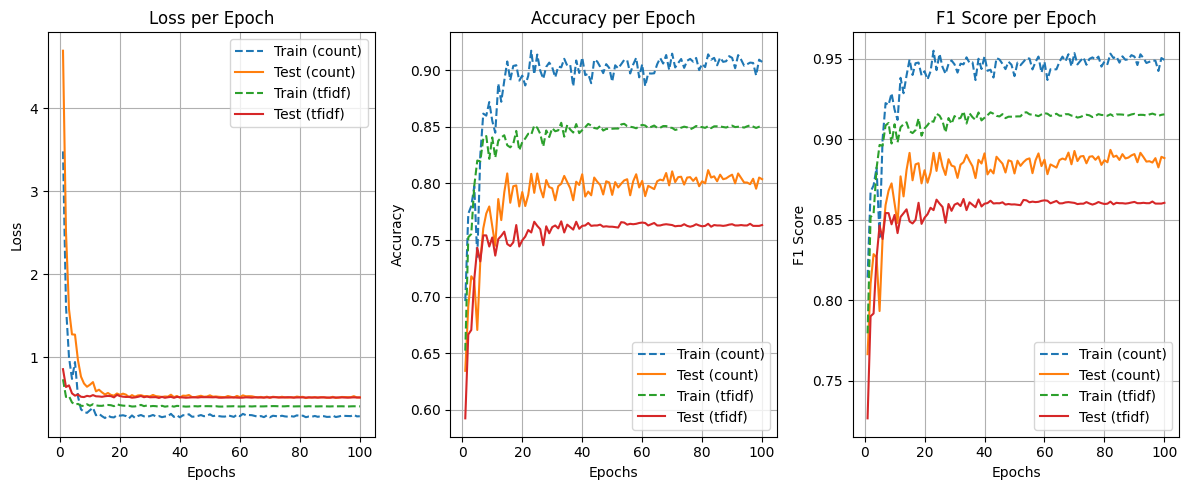

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))
for metric, title in zip(['losses', 'accuracies', 'f1s'], ['Loss', 'Accuracy', 'F1 Score']):
    plt.subplot(1, 3, ['losses', 'accuracies', 'f1s'].index(metric) + 1)
    for vec in vectorizer_types:
        plt.plot(range(1, epochs + 1), results[vec][f'train_{metric}'], label=f'Train ({vec})', linestyle='dashed')
        plt.plot(range(1, epochs + 1), results[vec][f'test_{metric}'], label=f'Test ({vec})')
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(title + ' per Epoch')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()